## Import Libraries and Data

In [1145]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
data = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration

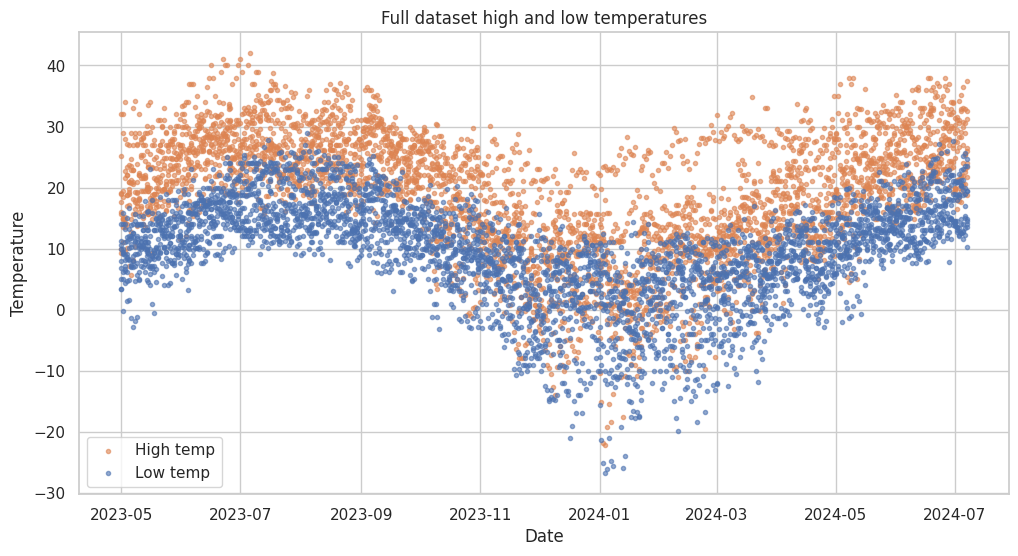

In [1146]:
# Plot the tempmax and tempmin columns
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(data.index, data['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(data.index, data['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [1147]:
print(data.shape)
data.isnull().sum()

(3906, 27)


location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [1148]:
data.duplicated().sum()

0

In [1149]:
# Drop Columns of No Interest
df = data.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

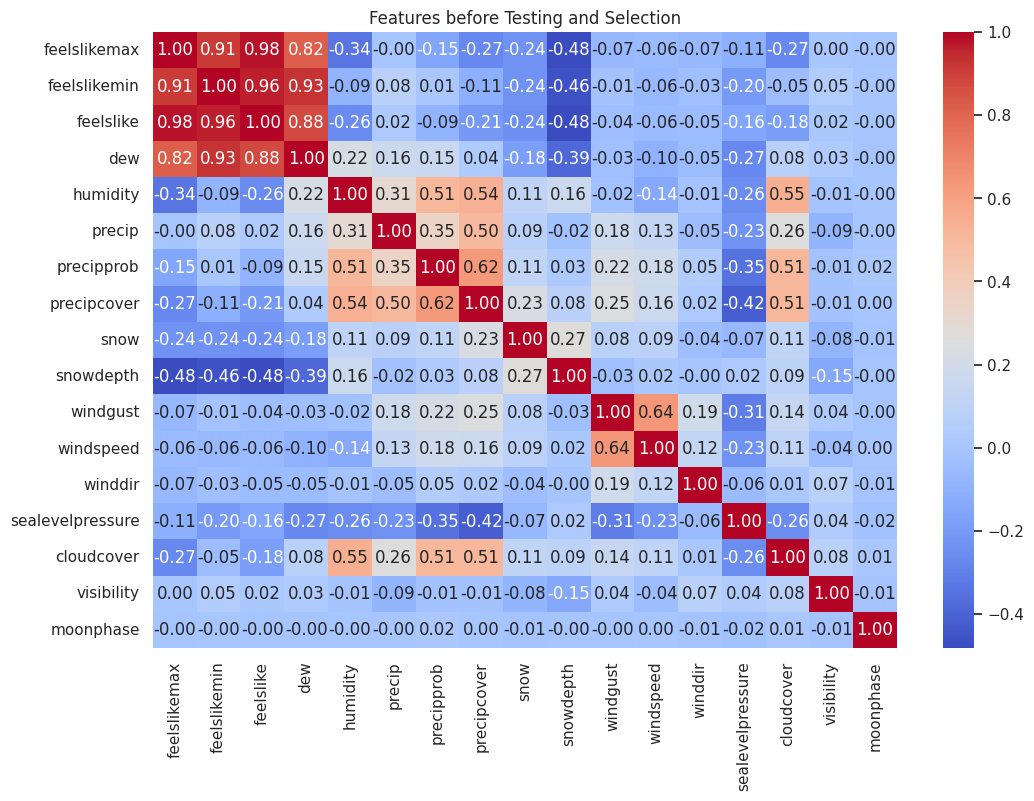

In [1150]:
all_features = df[['feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

df = df.select_dtypes(include=['number'])
correlation_matrix = all_features.corr()
plt.figure(figsize=(12, 8))
plt.title("Features before Testing and Selection")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## Feature Selection

In [1151]:
# Define the DataFrame with combined highly correlated features for tempmax and tempmin
df['feelslike_max_combined'] = df[['feelslikemax', 'feelslike']].mean(axis=1)
df['feelslike_min_combined'] = df[['feelslikemin', 'feelslike']].mean(axis=1)
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

# Recalculate the features DataFrame without the original features tempmax
features_combined_max = df[['feelslike_max_combined', 'dew_humidity', 'snow', 'snowdepth', 'visibility']]

# Recalculate the features DataFrame without the original features tempmin
features_combined_min = df[['feelslike_min_combined', 'dew_humidity', 'precipcover', 'snowdepth', 'visibility']]


In [1152]:
""" Addressing Multicollinearity with Variance Inflation Factor"""
# Calculate VIF for each feature in tempmax
vif_data_max = pd.DataFrame()
vif_data_max["tempmax feature"] = features_combined_max.columns
vif_data_max["VIF"] = [variance_inflation_factor(features_combined_max.values, i) for i in range(features_combined_max.shape[1])]

# Calculate VIF for each feature in tempmin
vif_data_min = pd.DataFrame()
vif_data_min["tempmin feature"] = features_combined_min.columns
vif_data_min["VIF"] = [variance_inflation_factor(features_combined_min.values, i) for i in range(features_combined_min.shape[1])]

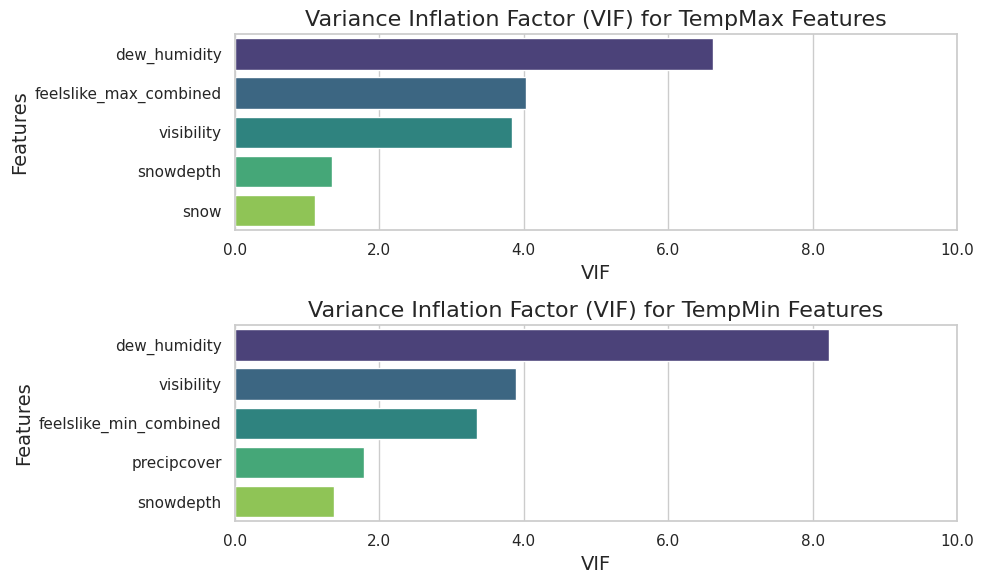

In [1153]:
# Plotting the VIF results for tempmax and tempmin as subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
sns.set(style="whitegrid")

# VIF for TempMax Features
sns.barplot(x="VIF", y="tempmax feature", hue="tempmax feature", dodge=False, data=vif_data_max.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[0], legend=False)
axes[0].set_title('Variance Inflation Factor (VIF) for TempMax Features', fontsize=16)
axes[0].set_xlabel('VIF', fontsize=14)
axes[0].set_ylabel('Features', fontsize=14)
axes[0].set_xlim(0, 10)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# VIF for TempMin Features
sns.barplot(x="VIF", y="tempmin feature", hue="tempmin feature", dodge=False, data=vif_data_min.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[1], legend=False)
axes[1].set_title('Variance Inflation Factor (VIF) for TempMin Features', fontsize=16)
axes[1].set_xlabel('VIF', fontsize=14)
axes[1].set_ylabel('Features', fontsize=14)
axes[1].set_xlim(0, 10)
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Adjust layout
plt.tight_layout()
plt.show()

## Hypothesis
"A higher dew point likely predicts a higher temperature across locations, making dew point a reliable temperature predictor irrespective of geography."

## Train-Test Split
### Translate Hypothesis to Testable Statements/Validate Features

In [1154]:
# Define target variables
y_max = df['tempmax']
y_min = df['tempmin']

# Define feature set with combined features
X_max = ['feelslike_max_combined', 'dew_humidity', 'snow', 'snowdepth']

X_min = ['feelslike_min_combined', 'dew_humidity', 'precipcover', 'snowdepth']

# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

# Split the data into before and after the split date
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

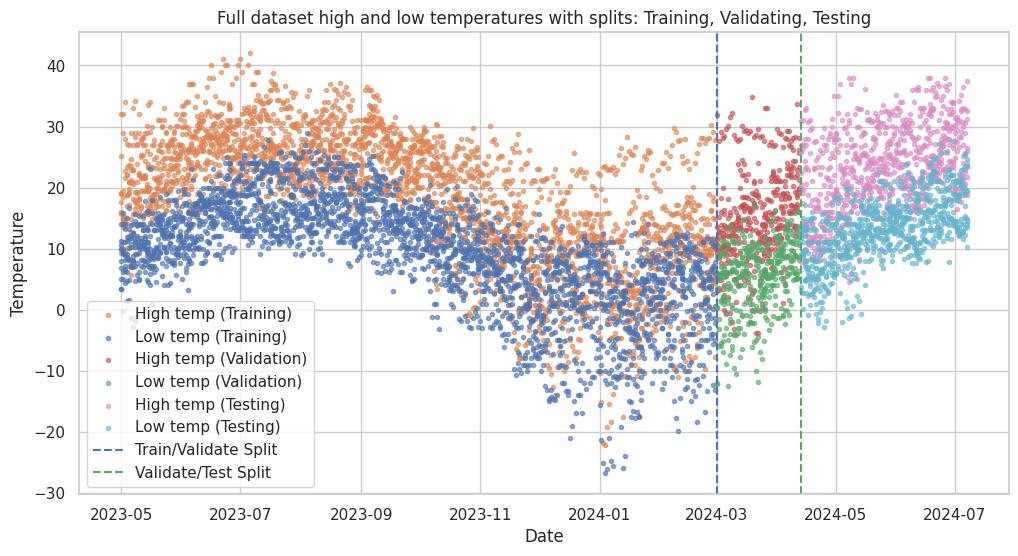

In [1155]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the tempmax and tempmin columns for training data
plt.scatter(train.index, train['tempmax'], color=color_pal[1], label='High temp (Training)', alpha=0.6, marker='.')
plt.scatter(train.index, train['tempmin'], color=color_pal[0], label='Low temp (Training)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for validation data
plt.scatter(validate.index, validate['tempmax'], color=color_pal[3], label='High temp (Validation)', alpha=0.6, marker='.')
plt.scatter(validate.index, validate['tempmin'], color=color_pal[2], label='Low temp (Validation)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for testing data
plt.scatter(test.index, test['tempmax'], color=color_pal[6], label='High temp (Testing)', alpha=0.6, marker='.')
plt.scatter(test.index, test['tempmin'], color=color_pal[9], label='Low temp (Testing)', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures with splits: Training, Validating, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[0], ls='--', label='Train/Validate Split')
ax.axvline(validate_end_date, color=color_pal[2], ls='--', label='Validate/Test Split')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [1156]:
# Define target variables
y_train_max = train['tempmax']
y_train_min = train['tempmin']
y_validate_max = validate['tempmax']
y_validate_min = validate['tempmin']
y_test_max = test['tempmax']
y_test_min = test['tempmin']

# Define feature sets tempmax
X_train_max = train[X_max]
X_validate_max = validate[X_max]
X_test_max = test[X_max]

# Define feature sets tempmin
X_train_min = train[X_min]
X_validate_min = validate[X_min]
X_test_min = test[X_min]

## Model Training and Evaluation
### Chose Ridge because of regularization needs to address overfitting after model cross validation

In [1157]:
# Function to evaluate a model
def evaluate_model(X_train, y_train, X_test, y_test, model_name):
    # Fit the model using statsmodels for detailed analysis
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    model_sm = sm.OLS(y_train, X_train_sm).fit()

    # Predictions
    y_train_pred = model_sm.predict(X_train_sm)
    y_test_pred = model_sm.predict(X_test_sm)

    # Goodness of fit
    print(f"Model Summary for {model_name}:")
    print(model_sm.summary())

    # Error metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f'Train RMSE for {model_name}: {train_rmse}, Test RMSE: {test_rmse}')
    print(f'Train MAE for {model_name}: {train_mae}, Test MAE: {test_mae}')
    print(f'Train R² for {model_name}: {train_r2}, Test R²: {test_r2}')

    # Multicollinearity
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_train.columns
    vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    print(f"VIF for {model_name}:\n", vif_data)

    # Residual analysis
    residuals = y_train - y_train_pred

    # Create subplots for residual analysis, Q-Q plot, and autocorrelation of residuals
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Residuals vs Predicted
    axs[0].scatter(y_train_pred, residuals)
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Residuals')
    axs[0].set_title(f'Residuals vs Predicted for {model_name}')

    # Q-Q Plot
    qqplot(residuals, line='s', ax=axs[1])
    axs[1].set_title(f'Q-Q Plot of Residuals for {model_name}')

    # Autocorrelation of Residuals
    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[2])
    axs[2].set_title(f'Autocorrelation of Residuals for {model_name}')

    plt.tight_layout()
    plt.show()

In [1158]:
# Define the parameter values based on hyperparameter tuning
alpha_max = 0.1
alpha_min = 10

# Initialize the scalers
scaler_max = StandardScaler()
scaler_min = StandardScaler()

# Fit and transform the training data
X_train_max_scaled = scaler_max.fit_transform(X_train_max)
X_train_min_scaled = scaler_min.fit_transform(X_train_min)

# Transform the test data using the same scaler
X_test_max_scaled = scaler_max.transform(X_test_max)
X_test_min_scaled = scaler_min.transform(X_test_min)

# Initialize and fit the Ridge Regression model for tempmax
ridge_model_max = Ridge(alpha=alpha_max)
ridge_model_max.fit(X_train_max_scaled, y_train_max)

# Make predictions on the test set for tempmax
y_pred_test_max = ridge_model_max.predict(X_test_max_scaled)

# Calculate R² for test set for tempmax
r2_test_max = r2_score(y_test_max, y_pred_test_max)
print(f"Ridge Regression Test R² for tempmax (after scaling): {r2_test_max}")

# Initialize and fit the Ridge Regression model for tempmin
ridge_model_min = Ridge(alpha=alpha_min)
ridge_model_min.fit(X_train_min_scaled, y_train_min)

# Make predictions on the test set for tempmin
y_pred_test_min = ridge_model_min.predict(X_test_min_scaled)

# Calculate R² for test set for tempmin
r2_test_min = r2_score(y_test_min, y_pred_test_min)
print(f"Ridge Regression Test R² for tempmin (after scaling): {r2_test_min}")


Ridge Regression Test R² for tempmax (after scaling): 0.9716331180803389
Ridge Regression Test R² for tempmin (after scaling): 0.9486250992542153


### Find Best HyperParameters

In [1159]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define parameter grid for alpha
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Initialize GridSearchCV
grid_search_max = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid_search_min = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')

# Fit GridSearchCV
grid_search_max.fit(X_train_max_scaled, y_train_max)
grid_search_min.fit(X_train_min_scaled, y_train_min)

# Get the best alpha
best_alpha_max = grid_search_max.best_params_['alpha']
best_alpha_min = grid_search_min.best_params_['alpha']

print(f"Best Alpha for TempMax: {best_alpha_max}")
print(f"Best Alpha for TempMin: {best_alpha_min}")

# Re-train the Ridge Regression models with the best alpha
ridge_model_max = Ridge(alpha=best_alpha_max)
ridge_model_max.fit(X_train_max_scaled, y_train_max)

ridge_model_min = Ridge(alpha=best_alpha_min)
ridge_model_min.fit(X_train_min_scaled, y_train_min)

# Predict and evaluate on the test set
y_pred_test_max = ridge_model_max.predict(X_test_max_scaled)
y_pred_test_min = ridge_model_min.predict(X_test_min_scaled)

r2_test_max = r2_score(y_test_max, y_pred_test_max)
r2_test_min = r2_score(y_test_min, y_pred_test_min)

print(f"Ridge Regression Test R² for TempMax (after scaling): {r2_test_max}")
print(f"Ridge Regression Test R² for TempMin (after scaling): {r2_test_min}")

# Cross-Validation Scores
cv_scores_max = cross_val_score(ridge_model_max, X_train_max_scaled, y_train_max, cv=5, scoring='r2')
cv_scores_min = cross_val_score(ridge_model_min, X_train_min_scaled, y_train_min, cv=5, scoring='r2')

print(f"Cross-Validation R² Scores for TempMax: {cv_scores_max}")
print(f"Cross-Validation R² Scores for TempMin: {cv_scores_min}")


Best Alpha for TempMax: 0.01
Best Alpha for TempMin: 10
Ridge Regression Test R² for TempMax (after scaling): 0.9716369499430254
Ridge Regression Test R² for TempMin (after scaling): 0.9486250992542153
Cross-Validation R² Scores for TempMax: [0.98173807 0.97479862 0.98520427 0.98791129 0.98361021]
Cross-Validation R² Scores for TempMin: [0.97555053 0.93416156 0.95909415 0.98156856 0.97046779]


Model Summary for TempMax:
                            OLS Regression Results                            
Dep. Variable:                tempmax   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 4.745e+04
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        08:01:57   Log-Likelihood:                -4500.9
No. Observations:                2745   AIC:                             9012.
Df Residuals:                    2740   BIC:                             9041.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
c

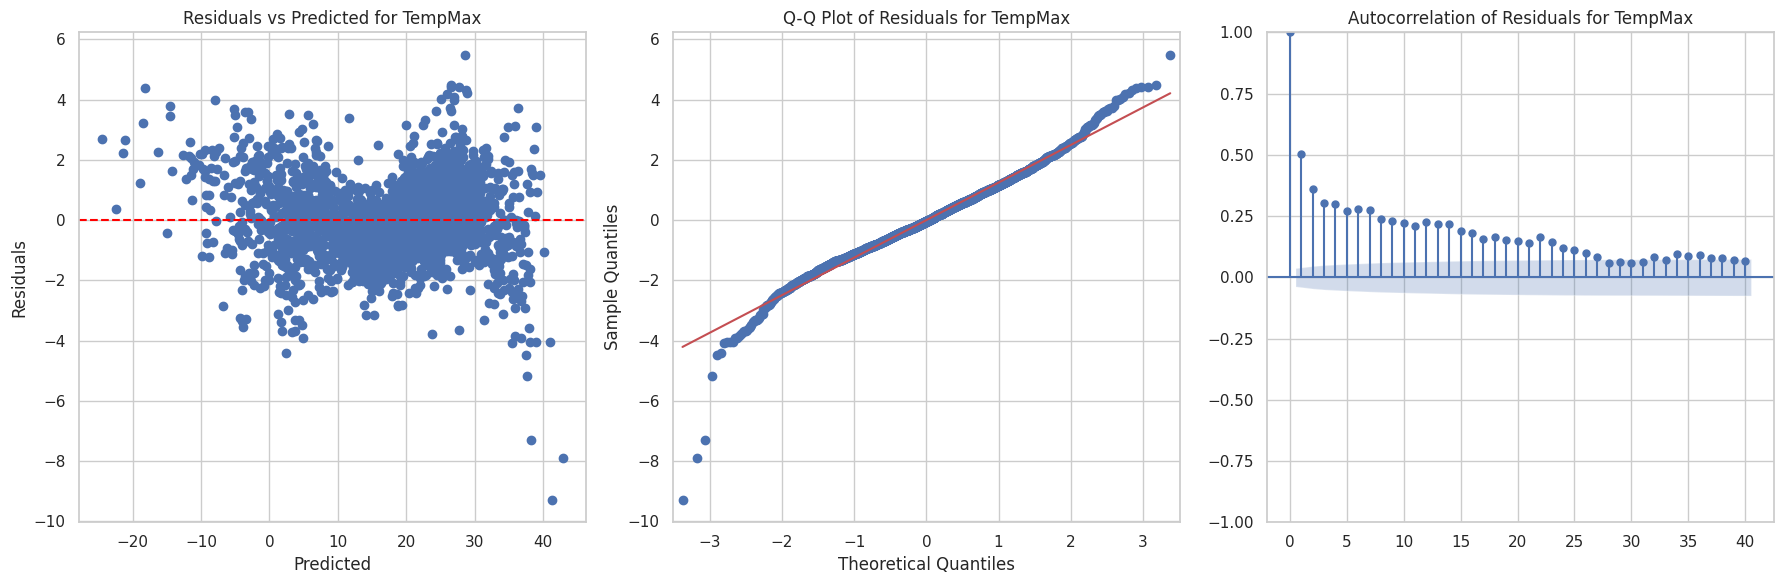

Model Summary for TempMin:
                            OLS Regression Results                            
Dep. Variable:                tempmin   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 2.612e+04
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        08:01:57   Log-Likelihood:                -4849.4
No. Observations:                2745   AIC:                             9709.
Df Residuals:                    2740   BIC:                             9738.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
c

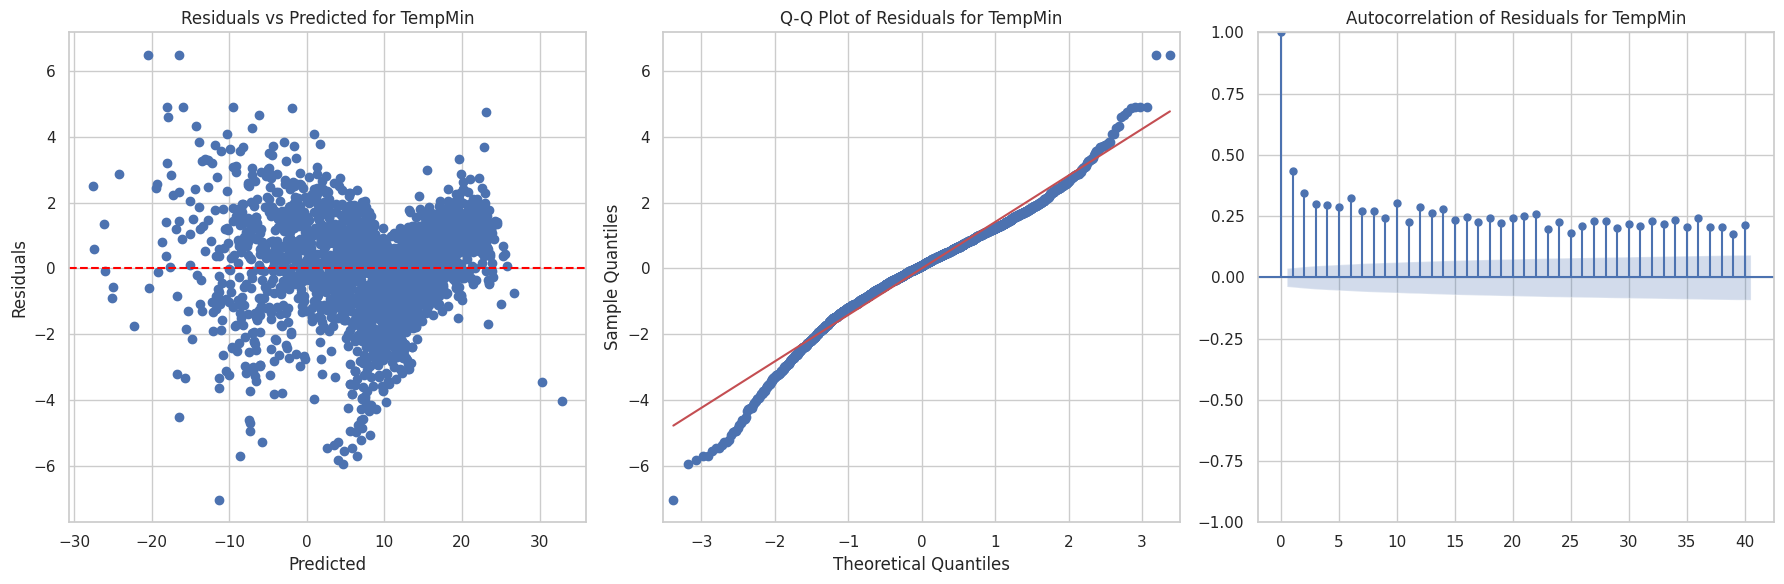

In [1160]:
# Evaluate the Ridge models
evaluate_model(X_train_max, y_train_max, X_validate_max, y_validate_max, 'TempMax')
evaluate_model(X_train_min, y_train_min, X_validate_min, y_validate_min, 'TempMin')

In [1161]:
# Feature importances for tempmax
importances_max = abs(ridge_model_max.coef_)
importance_df_max = pd.DataFrame({
    'Feature': X_train_max.columns,
    'Importance': importances_max
}).sort_values(by='Importance', ascending=False)

# Feature importances for tempmin
importances_min = abs(ridge_model_min.coef_)
importance_df_min = pd.DataFrame({
    'Feature': X_train_min.columns,
    'Importance': importances_min
}).sort_values(by='Importance', ascending=False)

print("Feature Importances from Ridge Regression for tempmax:")
print(importance_df_max)

print("Feature Importances from Ridge Regression for tempmin:")
print(importance_df_min)

Feature Importances from Ridge Regression for tempmax:
                  Feature  Importance
0  feelslike_max_combined   10.730627
1            dew_humidity    0.904393
3               snowdepth    0.376860
2                    snow    0.093492
Feature Importances from Ridge Regression for tempmin:
                  Feature  Importance
0  feelslike_min_combined    8.629178
1            dew_humidity    0.626477
2             precipcover    0.308293
3               snowdepth    0.202366


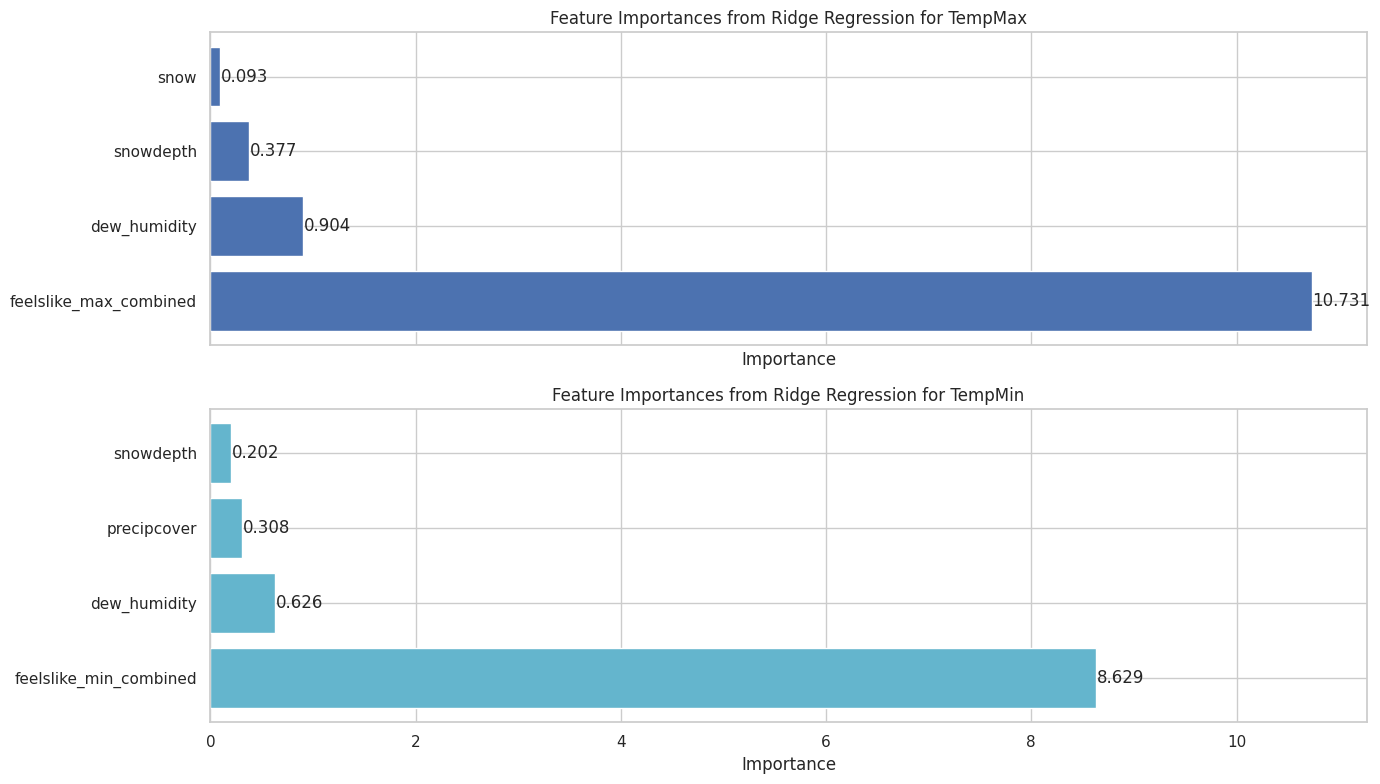

In [1162]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# TempMax Plot
ax1.barh(importance_df_max['Feature'], importance_df_max['Importance'], color=color_pal[0])
ax1.set_title('Feature Importances from Ridge Regression for TempMax')
ax1.set_xlabel('Importance')
for index, value in enumerate(importance_df_max['Importance']):
    ax1.text(value + 0.01, index, f'{value:.3f}', va='center')

# TempMin Plot
ax2.barh(importance_df_min['Feature'], importance_df_min['Importance'], color=color_pal[9])
ax2.set_title('Feature Importances from Ridge Regression for TempMin')
ax2.set_xlabel('Importance')
for index, value in enumerate(importance_df_min['Importance']):
    ax2.text(value + 0.01, index, f'{value:.3f}', va='center')

# Adjust layout
plt.tight_layout()
plt.show()

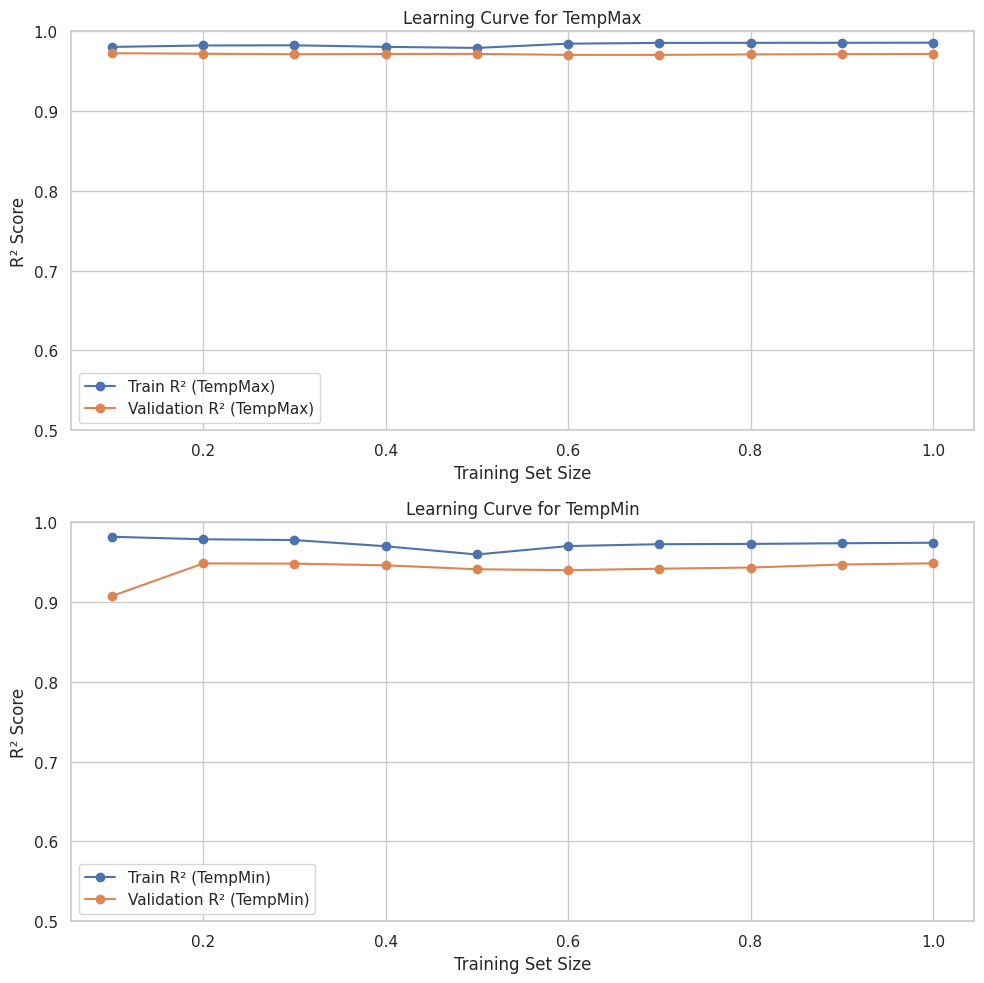

In [1163]:
# List to store results
train_sizes = np.linspace(0.1, 1.0, 10)
train_r2_max = []
val_r2_max = []
train_r2_min = []
val_r2_min = []

for train_size in train_sizes:
    # Calculate the number of samples for the current training subset size
    subset_size_max = int(train_size * len(X_train_max_scaled))
    subset_size_min = int(train_size * len(X_train_min_scaled))

    # Create training subsets
    X_train_max_subset = X_train_max_scaled[:subset_size_max]
    y_train_max_subset = y_train_max.iloc[:subset_size_max]

    X_train_min_subset = X_train_min_scaled[:subset_size_min]
    y_train_min_subset = y_train_min.iloc[:subset_size_min]

    # Initialize and fit the Ridge Regression model
    ridge_model_max = Ridge(alpha=alpha_max)
    ridge_model_max.fit(X_train_max_subset, y_train_max_subset)

    ridge_model_min = Ridge(alpha=alpha_min)
    ridge_model_min.fit(X_train_min_subset, y_train_min_subset)

    # Predict and evaluate
    y_train_pred_max = ridge_model_max.predict(X_train_max_subset)
    y_val_pred_max = ridge_model_max.predict(X_test_max_scaled)

    y_train_pred_min = ridge_model_min.predict(X_train_min_subset)
    y_val_pred_min = ridge_model_min.predict(X_test_min_scaled)

    # Compute R²
    train_r2_max.append(r2_score(y_train_max_subset, y_train_pred_max))
    val_r2_max.append(r2_score(y_test_max, y_val_pred_max))

    train_r2_min.append(r2_score(y_train_min_subset, y_train_pred_min))
    val_r2_min.append(r2_score(y_test_min, y_val_pred_min))

# Plot learning curves
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# TempMax Learning Curve
ax[0].plot(train_sizes, train_r2_max, label='Train R² (TempMax)', marker='o')
ax[0].plot(train_sizes, val_r2_max, label='Validation R² (TempMax)', marker='o')
ax[0].set_title('Learning Curve for TempMax')
ax[0].set_xlabel('Training Set Size')
ax[0].set_ylabel('R² Score')
ax[0].legend()
ax[0].grid(True)
ax[0].set_ylim(0.5, 1.0)  # Set y-axis limit for TempMax

# TempMin Learning Curve
ax[1].plot(train_sizes, train_r2_min, label='Train R² (TempMin)', marker='o')
ax[1].plot(train_sizes, val_r2_min, label='Validation R² (TempMin)', marker='o')
ax[1].set_title('Learning Curve for TempMin')
ax[1].set_xlabel('Training Set Size')
ax[1].set_ylabel('R² Score')
ax[1].legend()
ax[1].grid(True)
ax[1].set_ylim(0.5, 1.0)  # Set y-axis limit for TempMin

plt.tight_layout()
plt.show()

## Address Heteroskedasticity and Autocorrelation

In [1164]:
import statsmodels.stats.api as sms

# Calculate residuals
residuals_max = y_train_max - ridge_model_max.predict(X_train_max_scaled)
residuals_min = y_train_min - ridge_model_min.predict(X_train_min_scaled)

# Perform Breusch-Pagan test for tempmax
bp_test_max = sms.het_breuschpagan(residuals_max, sm.add_constant(X_train_max_scaled))
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test_max_results = dict(zip(labels, bp_test_max))
print('Breusch-Pagan test for TempMax:')
print(bp_test_max_results)

# Perform Breusch-Pagan test for tempmin
bp_test_min = sms.het_breuschpagan(residuals_min, sm.add_constant(X_train_min_scaled))
bp_test_min_results = dict(zip(labels, bp_test_min))
print('Breusch-Pagan test for TempMin:')
print(bp_test_min_results)

# Perform White test for tempmax
white_test_max = sms.het_white(residuals_max, sm.add_constant(X_train_max_scaled))
white_test_max_results = dict(zip(labels, white_test_max))
print('White test for TempMax:')
print(white_test_max_results)

# Perform White test for tempmin
white_test_min = sms.het_white(residuals_min, sm.add_constant(X_train_min_scaled))
white_test_min_results = dict(zip(labels, white_test_min))
print('White test for TempMin:')
print(white_test_min_results)

Breusch-Pagan test for TempMax:
{'Lagrange multiplier statistic': 36.373600427161755, 'p-value': 2.42423980096854e-07, 'f-value': 9.198727553026561, 'f p-value': 2.215699259623549e-07}
Breusch-Pagan test for TempMin:
{'Lagrange multiplier statistic': 394.1507275793341, 'p-value': 5.106078053409341e-84, 'f-value': 114.84923834093041, 'f p-value': 1.1775513987479116e-90}
White test for TempMax:
{'Lagrange multiplier statistic': 319.85898825029864, 'p-value': 8.438015284117799e-60, 'f-value': 25.719124127882125, 'f p-value': 8.490814879138079e-64}
White test for TempMin:
{'Lagrange multiplier statistic': 476.3728542948549, 'p-value': 9.378877407394176e-93, 'f-value': 40.94666096337457, 'f p-value': 2.5826698816891737e-102}


In [1165]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Transform the validation data using the same scalers
X_validate_max_scaled = scaler_max.transform(X_validate_max)
X_validate_min_scaled = scaler_min.transform(X_validate_min)

# Transform the test data using the same scalers
X_test_max_scaled = scaler_max.transform(X_test_max)
X_test_min_scaled = scaler_min.transform(X_test_min)

# Make predictions on the validation set
y_pred_validate_max = ridge_model_max.predict(X_validate_max_scaled)
y_pred_validate_min = ridge_model_min.predict(X_validate_min_scaled)

# Make predictions on the test set
y_pred_test_max = ridge_model_max.predict(X_test_max_scaled)
y_pred_test_min = ridge_model_min.predict(X_test_min_scaled)

# Calculate and print evaluation metrics for TempMax
mse_test_max = mean_squared_error(y_test_max, y_pred_test_max)
mae_test_max = mean_absolute_error(y_test_max, y_pred_test_max)
r2_test_max = r2_score(y_test_max, y_pred_test_max)
print(f'Test MSE for TempMax: {mse_test_max}')
print(f'Test MAE for TempMax: {mae_test_max}')
print(f'Test R² for TempMax: {r2_test_max}')

# Calculate and print evaluation metrics for TempMin
mse_test_min = mean_squared_error(y_test_min, y_pred_test_min)
mae_test_min = mean_absolute_error(y_test_min, y_pred_test_min)
r2_test_min = r2_score(y_test_min, y_pred_test_min)
print(f'Test MSE for TempMin: {mse_test_min}')
print(f'Test MAE for TempMin: {mae_test_min}')
print(f'Test R² for TempMin: {r2_test_min}')


Test MSE for TempMax: 1.2845435016038933
Test MAE for TempMax: 0.8774901495871692
Test R² for TempMax: 0.9716331180803389
Test MSE for TempMin: 1.4037446692896371
Test MAE for TempMin: 0.9077408024997367
Test R² for TempMin: 0.9486250992542153


## Robust Error Metrics and Transformation
(adjust the standard errors of the coefficient estimates to be valid under the presence of heteroskedasticity)

In [1167]:
import statsmodels.api as sm

# Add a constant to the features
X_train_max_sm = sm.add_constant(X_train_max_scaled)
X_train_min_sm = sm.add_constant(X_train_min_scaled)

# Fit the OLS model with robust standard errors for tempmax
model_max = sm.OLS(y_train_max, X_train_max_sm).fit(cov_type='HC3')
print(model_max.summary())

# Fit the OLS model with robust standard errors for tempmin
model_min = sm.OLS(y_train_min, X_train_min_sm).fit(cov_type='HC3')
print(model_min.summary())


                            OLS Regression Results                            
Dep. Variable:                tempmax   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 2.640e+04
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        08:04:46   Log-Likelihood:                -4500.9
No. Observations:                2745   AIC:                             9012.
Df Residuals:                    2740   BIC:                             9041.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.2320      0.024    763.967      0.0

In [1169]:
import statsmodels.api as sm
import numpy as np

# Add a constant to the features for OLS regression
X_train_max_sm = sm.add_constant(X_train_max_scaled)
X_train_min_sm = sm.add_constant(X_train_min_scaled)
X_test_max_sm = sm.add_constant(X_test_max_scaled)
X_test_min_sm = sm.add_constant(X_test_min_scaled)

# Fit the OLS model with robust standard errors for TempMax
model_max = sm.OLS(y_train_max, X_train_max_sm).fit(cov_type='HC3')
print(model_max.summary())

# Fit the OLS model with robust standard errors for TempMin
model_min = sm.OLS(y_train_min, X_train_min_sm).fit(cov_type='HC3')
print(model_min.summary())

# Make predictions on the test set
y_pred_test_max_robust = model_max.predict(X_test_max_sm)
y_pred_test_min_robust = model_min.predict(X_test_min_sm)

# Calculate evaluation metrics for TempMax
mse_test_max_robust = mean_squared_error(y_test_max, y_pred_test_max_robust)
mae_test_max_robust = mean_absolute_error(y_test_max, y_pred_test_max_robust)
r2_test_max_robust = r2_score(y_test_max, y_pred_test_max_robust)
print(f'Test MSE for TempMax with robust standard errors: {mse_test_max_robust}')
print(f'Test MAE for TempMax with robust standard errors: {mae_test_max_robust}')
print(f'Test R² for TempMax with robust standard errors: {r2_test_max_robust}')

# Calculate evaluation metrics for TempMin
mse_test_min_robust = mean_squared_error(y_test_min, y_pred_test_min_robust)
mae_test_min_robust = mean_absolute_error(y_test_min, y_pred_test_min_robust)
r2_test_min_robust = r2_score(y_test_min, y_pred_test_min_robust)
print(f'Test MSE for TempMin with robust standard errors: {mse_test_min_robust}')
print(f'Test MAE for TempMin with robust standard errors: {mae_test_min_robust}')
print(f'Test R² for TempMin with robust standard errors: {r2_test_min_robust}')


                            OLS Regression Results                            
Dep. Variable:                tempmax   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 2.640e+04
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        08:06:49   Log-Likelihood:                -4500.9
No. Observations:                2745   AIC:                             9012.
Df Residuals:                    2740   BIC:                             9041.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.2320      0.024    763.967      0.0

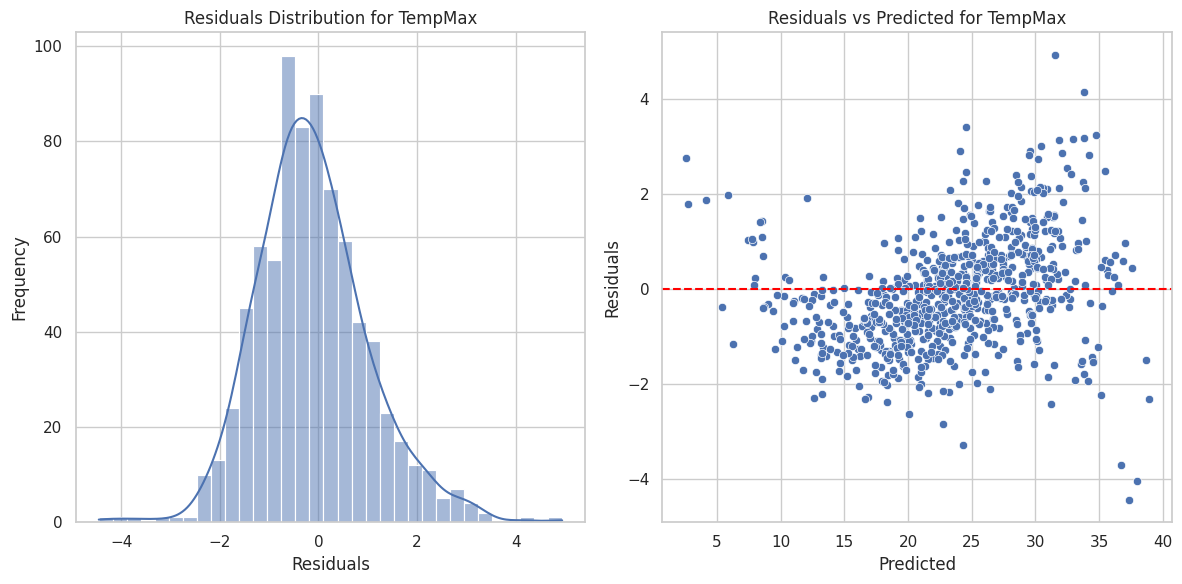

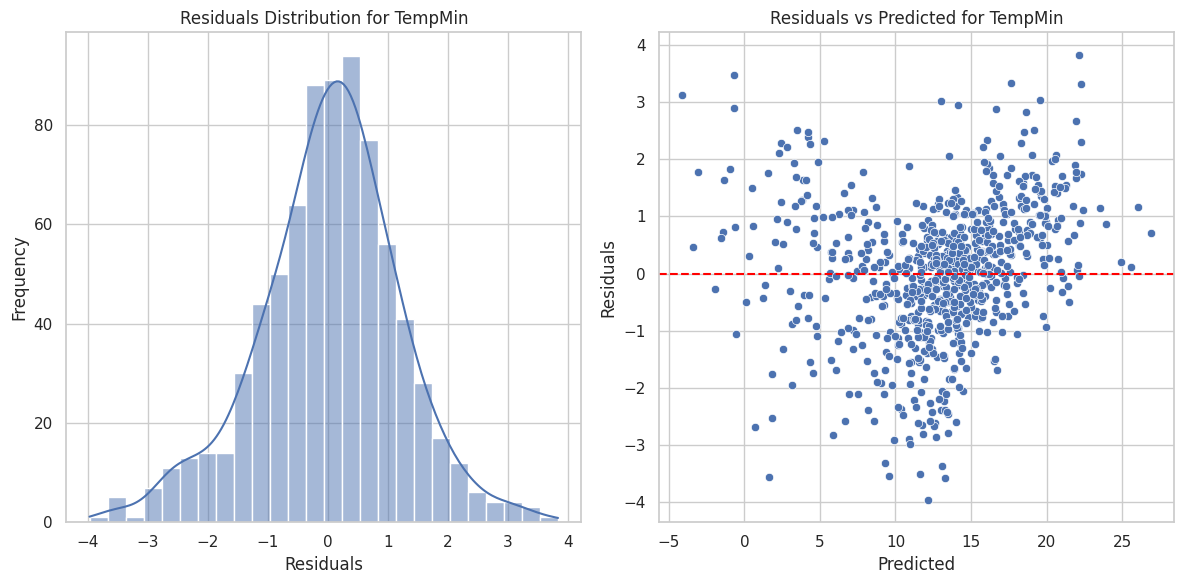

In [1170]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residual plots for TempMax
residuals_max = y_test_max - y_pred_test_max_robust

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals_max, kde=True)
plt.title('Residuals Distribution for TempMax')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_test_max_robust, y=residuals_max)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted for TempMax')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Residual plots for TempMin
residuals_min = y_test_min - y_pred_test_min_robust

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals_min, kde=True)
plt.title('Residuals Distribution for TempMin')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_test_min_robust, y=residuals_min)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted for TempMin')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


## Cross Validation Before Completion

In [1166]:
from sklearn.model_selection import cross_val_score, KFold

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Ridge Regression models with the selected alpha
ridge_model_max = Ridge(alpha=alpha_max)
ridge_model_min = Ridge(alpha=alpha_min)

# Perform cross-validation
cv_scores_max = cross_val_score(ridge_model_max, X_train_max_scaled, y_train_max, cv=cv, scoring='r2')
cv_scores_min = cross_val_score(ridge_model_min, X_train_min_scaled, y_train_min, cv=cv, scoring='r2')

# Print the cross-validation results
print(f"Cross-Validation R² Scores for TempMax: {cv_scores_max}")
print(f"Mean Cross-Validation R² for TempMax: {cv_scores_max.mean():.4f} ± {cv_scores_max.std():.4f}")

print(f"Cross-Validation R² Scores for TempMin: {cv_scores_min}")
print(f"Mean Cross-Validation R² for TempMin: {cv_scores_min.mean():.4f} ± {cv_scores_min.std():.4f}")


Cross-Validation R² Scores for TempMax: [0.98434433 0.98734174 0.9870057  0.98399436 0.98564814]
Mean Cross-Validation R² for TempMax: 0.9857 ± 0.0014
Cross-Validation R² Scores for TempMin: [0.9744568  0.97566203 0.9717769  0.97633002 0.97293604]
Mean Cross-Validation R² for TempMin: 0.9742 ± 0.0017


# Next steps:
- Residual Analysis, no remaining heteroskedasticity issues
- Test final model evaluation/maybe try time series models
- Rename variables and clean/simplify notebook
- Documentation and Reporting
- Plot predicted vs actual value